In [1]:
import requests
import pandas as pd

BASE_URL = "https://ghoapi.azureedge.net/api/"
INDICATOR = "MH_12"  # Mental health indicator

rows = []
skip = 0
page_size = 1000

while True:
    params = {"$top": page_size, "$skip": skip}
    response = requests.get(f"{BASE_URL}{INDICATOR}", params=params)
    data = response.json()
    records = data.get("value", [])

    if not records:
        break

    for item in records:
        if item.get("NumericValue") is not None:
            rows.append({
                "country_name": item.get("SpatialDim"),
                "year": int(item.get("TimeDim")),
                "mental_health_value": item.get("NumericValue"),
                "indicator_code": item.get("IndicatorCode")
            })
    skip += page_size

# Convert to DataFrame
who_df = pd.DataFrame(rows)

# Save raw data
who_df.to_json("Raw Data//who_mental_health_raw.json", orient="records", indent=4)
print("WHO data fetched:", who_df.shape)


WHO data fetched: (12936, 4)


In [2]:
who_df


,country_name,year,mental_health_value,indicator_code
0,LTU,2012,52.254544,MH_12
1,JOR,2010,1.670238,MH_12
2,SSD,2020,5.916572,MH_12
3,SYR,2001,1.809799,MH_12
4,ZWE,2021,25.423327,MH_12
...,...,...,...,...
12931,CRI,2004,2.259396,MH_12
12932,BRN,2015,1.193121,MH_12
12933,KEN,2014,9.083175,MH_12
12934,COD,2013,23.642500,MH_12


In [3]:
print(who_df.isna().sum())


country_name           0
year                   0
mental_health_value    0
indicator_code         0
dtype: int64


In [4]:
import requests
import pandas as pd

# World Bank indicators
indicators = {
    "GDP_per_capita": "NY.GDP.PCAP.CD",
    "Unemployment": "SL.UEM.TOTL.ZS",
    "School_enrollment": "SE.SEC.ENRR"
}

wb_rows = []

for name, code in indicators.items():
    url = f"http://api.worldbank.org/v2/country/all/indicator/{code}?format=json&per_page=20000"
    response = requests.get(url)
    data = response.json()
    records = data[1]  # Actual data

    for item in records:
        wb_rows.append({
            "country_name": item["country"]["value"],  # use country name
            "year": int(item["date"]),
            "indicator": name,
            "value": item["value"]  # keep raw value, even if None
        })

# Convert to DataFrame
wb_df_raw = pd.DataFrame(wb_rows)
# Filter years to match WHO data (e.g., 2000–2023)
wb_df_raw = wb_df_raw[(wb_df_raw['year'] >= 2000) & (wb_df_raw['year'] <= 2023)]

# Pivot indicators to separate columns
wb_df_raw = wb_df_raw.pivot_table(index=["country_name", "year"],
                                  columns="indicator",
                                  values="value").reset_index()
wb_df_raw.columns.name = None

# Save raw data for later cleaning
wb_df_raw.to_csv("Raw Data//world_bank_data_raw.csv", index=False)
wb_df_raw.to_json("Raw Data//world_bank_data_raw.json", orient="records", indent=4)

print("Raw World Bank data fetched:", wb_df_raw.shape)


Raw World Bank data fetched: (6301, 5)


In [5]:
wb_df_raw

,country_name,year,GDP_per_capita,School_enrollment,Unemployment
0,Afghanistan,2000,174.930991,NaN,7.897
1,Afghanistan,2001,138.706822,14.04041,7.973
2,Afghanistan,2002,178.954088,NaN,7.867
3,Afghanistan,2003,198.871116,13.95953,7.844
4,Afghanistan,2004,221.763654,19.21438,7.794
...,...,...,...,...,...
6296,Zimbabwe,2019,2184.329239,NaN,7.373
6297,Zimbabwe,2020,2059.674454,NaN,8.617
6298,Zimbabwe,2021,2613.605421,NaN,9.540
6299,Zimbabwe,2022,2536.400502,NaN,10.087


In [6]:
print(wb_df_raw.isna().sum())


country_name            0
year                    0
GDP_per_capita        108
School_enrollment    1707
Unemployment          665
dtype: int64


In [7]:


# WB raw data
print("WB missing values:\n", wb_df_raw.isna().sum())

print("WB duplicates:", wb_df_raw.duplicated().sum())


WB missing values:
 country_name            0
year                    0
GDP_per_capita        108
School_enrollment    1707
Unemployment          665
dtype: int64
WB duplicates: 0


In [8]:
# Load raw data
wb_df = pd.read_csv("Raw Data//world_bank_data_raw.csv")
wb_df

,country_name,year,GDP_per_capita,School_enrollment,Unemployment
0,Afghanistan,2000,174.930991,NaN,7.897
1,Afghanistan,2001,138.706822,14.04041,7.973
2,Afghanistan,2002,178.954088,NaN,7.867
3,Afghanistan,2003,198.871116,13.95953,7.844
4,Afghanistan,2004,221.763654,19.21438,7.794
...,...,...,...,...,...
6296,Zimbabwe,2019,2184.329239,NaN,7.373
6297,Zimbabwe,2020,2059.674454,NaN,8.617
6298,Zimbabwe,2021,2613.605421,NaN,9.540
6299,Zimbabwe,2022,2536.400502,NaN,10.087


In [9]:
# Fill missing values for each column
for col in ["GDP_per_capita", "School_enrollment", "Unemployment"]:
    wb_df[col] = wb_df[col].fillna(wb_df[col].mean())

In [10]:
# Save cleaned dataset
wb_df.to_csv("world_bank_data_clean.csv", index=False)

In [11]:
print("World Bank data cleaned:", wb_df.shape)


World Bank data cleaned: (6301, 5)


In [12]:
print(wb_df.isna().sum())


country_name         0
year                 0
GDP_per_capita       0
School_enrollment    0
Unemployment         0
dtype: int64


In [13]:
# Merge on country name and year
final_df = pd.merge(
    who_df,
    wb_df,
    on=["country_name", "year"],
    how="inner"  # only matching rows
)

# Save final dataset
final_df.to_csv("merge_dataset.csv", index=False)

print("Final merged dataset:", final_df.shape)
print(final_df.head())


Final merged dataset: (0, 7)
Empty DataFrame
Columns: [country_name, year, mental_health_value, indicator_code, GDP_per_capita, School_enrollment, Unemployment]
Index: []


In [14]:
from thefuzz import process
import pandas as pd

# wb_df and who_df are your DataFrames
# List of WB country names
wb_names_list = wb_df["country_name"].unique()

# Function to match WHO country names to WB names
def match_name_to_wb(who_country):
    match, score = process.extractOne(who_country, wb_names_list)
    if score >= 90:  # high similarity threshold
        return match
    else:
        return None

# Apply fuzzy matching
who_df["country_name_matched"] = who_df["country_name"].apply(match_name_to_wb)

# Merge on matched names + year
final_df = pd.merge(
    who_df,
    wb_df,
    left_on=["country_name_matched", "year"],
    right_on=["country_name", "year"],
    how="inner"
)

print("Merged dataset shape:", final_df.shape)
print(final_df.head())


Merged dataset shape: (5202, 9)
  country_name_x  year  mental_health_value indicator_code  \
0            JOR  2010             1.670238          MH_12   
1            SYR  2001             1.809799          MH_12   
2            TUN  2011             1.596429          MH_12   
3            AGO  2017            20.410024          MH_12   
4            UGA  2000            24.813049          MH_12   

   country_name_matched        country_name_y  GDP_per_capita  \
0                Jordan                Jordan     3718.465716   
1  Syrian Arab Republic  Syrian Arab Republic     1186.829135   
2               Tunisia               Tunisia     4420.647722   
3   Trinidad and Tobago   Trinidad and Tobago    17566.099970   
4              Portugal              Portugal    11526.372067   

   School_enrollment  Unemployment  
0          87.364441        12.500  
1          44.838951        11.630  
2          89.341469        18.334  
3          79.720263         3.389  
4         108.37288

In [15]:
# Missing values
print("Final merged dataset missing values:\n", final_df.isna().sum())

# Number of unmatched countries
unmatched_countries = who_df[who_df["country_name_matched"].isna()]
print("Number of WHO countries not matched to WB:", unmatched_countries.shape[0])

# Duplicates
print("Duplicates in merged dataset:", final_df.duplicated(subset=["country_name_y","year"]).sum())


Final merged dataset missing values:
 country_name_x          0
year                    0
mental_health_value     0
indicator_code          0
country_name_matched    0
country_name_y          0
GDP_per_capita          0
School_enrollment       0
Unemployment            0
dtype: int64
Number of WHO countries not matched to WB: 7722
Duplicates in merged dataset: 3621


In [16]:
final_df

,country_name_x,year,mental_health_value,indicator_code,country_name_matched,country_name_y,GDP_per_capita,School_enrollment,Unemployment
0,JOR,2010,1.670238,MH_12,Jordan,Jordan,3718.465716,87.364441,12.500
1,SYR,2001,1.809799,MH_12,Syrian Arab Republic,Syrian Arab Republic,1186.829135,44.838951,11.630
2,TUN,2011,1.596429,MH_12,Tunisia,Tunisia,4420.647722,89.341469,18.334
3,AGO,2017,20.410024,MH_12,Trinidad and Tobago,Trinidad and Tobago,17566.099970,79.720263,3.389
4,UGA,2000,24.813049,MH_12,Portugal,Portugal,11526.372067,108.372887,3.806
...,...,...,...,...,...,...,...,...,...
5197,KAZ,2012,44.878845,MH_12,Kazakhstan,Kazakhstan,12018.796653,99.018019,5.290
5198,JOR,2017,0.881077,MH_12,Jordan,Jordan,4065.616287,88.875829,18.120
5199,POL,2010,15.545104,MH_12,French Polynesia,French Polynesia,22494.806706,79.720263,12.133
5200,UKR,2020,32.485972,MH_12,Ukraine,Ukraine,3709.769287,84.428334,9.475


In [17]:
# Check some random rows
print(final_df[['country_name_x','country_name_matched','country_name_y','year','mental_health_value','GDP_per_capita']].head(10))

# Count rows per country
print(final_df.groupby('country_name_y').size().sort_values(ascending=False))

# Check for NaNs in important columns
print(final_df[['mental_health_value','GDP_per_capita','School_enrollment','Unemployment']].isna().sum())


  country_name_x  country_name_matched        country_name_y  year  \
0            JOR                Jordan                Jordan  2010   
1            SYR  Syrian Arab Republic  Syrian Arab Republic  2001   
2            TUN               Tunisia               Tunisia  2011   
3            AGO   Trinidad and Tobago   Trinidad and Tobago  2017   
4            UGA              Portugal              Portugal  2000   
5            AUS             Australia             Australia  2016   
6            BRA                Brazil                Brazil  2017   
7            AGO   Trinidad and Tobago   Trinidad and Tobago  2000   
8            PAN                 Japan                 Japan  2019   
9            VEN              Slovenia              Slovenia  2006   

   mental_health_value  GDP_per_capita  
0             1.670238     3718.465716  
1             1.809799     1186.829135  
2             1.596429     4420.647722  
3            20.410024    17566.099970  
4            24.813049  

In [18]:
from pymongo import MongoClient

# Connect
client = MongoClient("mongodb://localhost:27017/")
db = client["mental_health_project"]
collection = db["mental_health_data"]

# Prepare data
data_dict = final_df.to_dict("records")

# Insert
if data_dict:
    collection.insert_many(data_dict)
    print("Data inserted into MongoDB!")
else:
    print("No data to insert.")


Data inserted into MongoDB!


In [19]:
jordan_data = list(collection.find({"country_name_y": "Jordan"}))
print(jordan_data[:5])


[{'_id': ObjectId('6980ea23aa7e4796752e5e26'), 'country_name_x': 'JOR', 'year': 2010, 'mental_health_value': 1.67023763, 'indicator_code': 'MH_12', 'country_name_matched': 'Jordan', 'country_name_y': 'Jordan', 'GDP_per_capita': 3718.46571622945, 'School_enrollment': 87.3644409179688, 'Unemployment': 12.5}, {'_id': ObjectId('6980ea23aa7e4796752e5ee3'), 'country_name_x': 'JOR', 'year': 2019, 'mental_health_value': 1.26242816, 'indicator_code': 'MH_12', 'country_name_matched': 'Jordan', 'country_name_y': 'Jordan', 'GDP_per_capita': 4170.1144003465, 'School_enrollment': 89.5104774843719, 'Unemployment': 16.801}, {'_id': ObjectId('6980ea23aa7e4796752e5ffb'), 'country_name_x': 'JOR', 'year': 2006, 'mental_health_value': 2.200638861, 'indicator_code': 'MH_12', 'country_name_matched': 'Jordan', 'country_name_y': 'Jordan', 'GDP_per_capita': 2342.63459574933, 'School_enrollment': 86.7745513916016, 'Unemployment': 14.0}, {'_id': ObjectId('6980ea23aa7e4796752e603f'), 'country_name_x': 'JOR', 'year

In [20]:
high_mh_2010 = list(collection.find({"year": 2010, "mental_health_value": {"$gt": 20}}))
for row in high_mh_2010[:5]:
    print(row)


{'_id': ObjectId('6980ea23aa7e4796752e5ef2'), 'country_name_x': 'EST', 'year': 2010, 'mental_health_value': 26.63612919, 'indicator_code': 'MH_12', 'country_name_matched': 'Estonia', 'country_name_y': 'Estonia', 'GDP_per_capita': 14663.7041018705, 'School_enrollment': 110.888679504395, 'Unemployment': 16.707}
{'_id': ObjectId('6980ea23aa7e4796752e5f57'), 'country_name_x': 'SUR', 'year': 2010, 'mental_health_value': 40.85104045, 'indicator_code': 'MH_12', 'country_name_matched': 'Suriname', 'country_name_y': 'Suriname', 'GDP_per_capita': 7943.60482816915, 'School_enrollment': 71.4902572631836, 'Unemployment': 7.15}
{'_id': ObjectId('6980ea23aa7e4796752e5f5f'), 'country_name_x': 'AGO', 'year': 2010, 'mental_health_value': 22.15337083, 'indicator_code': 'MH_12', 'country_name_matched': 'Trinidad and Tobago', 'country_name_y': 'Trinidad and Tobago', 'GDP_per_capita': 16815.424737361, 'School_enrollment': 79.72026252508348, 'Unemployment': 4.033}
{'_id': ObjectId('6980ea23aa7e4796752e602c')

In [21]:
print(final_df.describe())

# Mental health value
print(final_df["mental_health_value"].describe())

# Correlation with socio-economic factors
print(final_df[["mental_health_value","GDP_per_capita","School_enrollment","Unemployment"]].corr())


              year  mental_health_value  GDP_per_capita  School_enrollment  \
count  5202.000000          5202.000000     5202.000000        5202.000000   
mean   2010.514418            10.679342    14889.802639          85.519305   
std       6.342518             9.777271    20919.102313          22.962726   
min    2000.000000             0.260438      109.593814           5.940960   
25%    2005.000000             4.156949     1639.852747          79.720263   
50%    2011.000000             7.859809     5971.607816          83.866985   
75%    2016.000000            14.060616    19030.628130         100.825877   
max    2021.000000            86.948011   134965.815442         159.110764   

       Unemployment  
count   5202.000000  
mean       8.263340  
std        5.049034  
min        0.100000  
25%        4.763000  
50%        7.757838  
75%       10.655000  
max       29.770000  
count    5202.000000
mean       10.679342
std         9.777271
min         0.260438
25%         4.1

C:\Users\lenovo\AppData\Local\Temp\ipykernel_42184\3436175350.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=final_df, x="year", y="mental_health_value", ci=None)


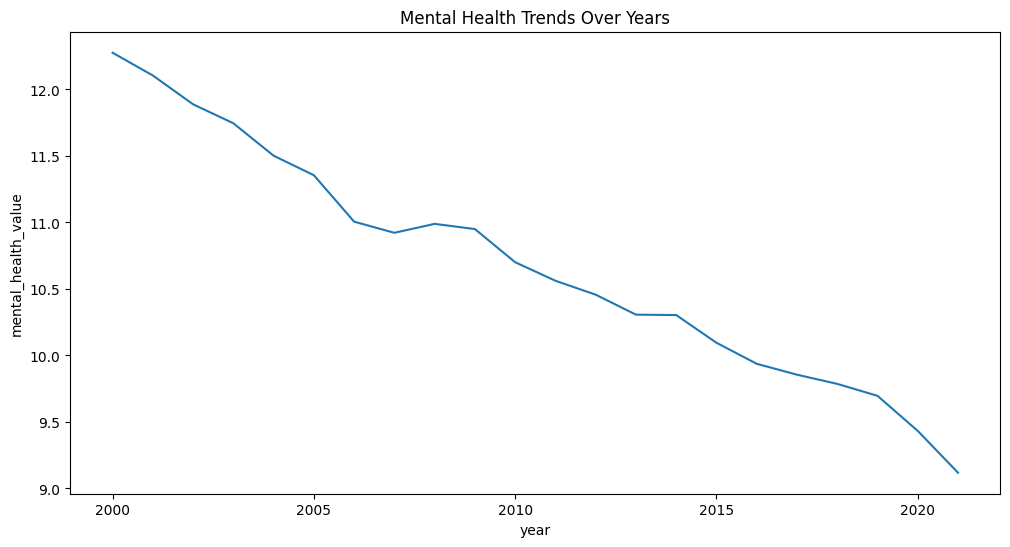

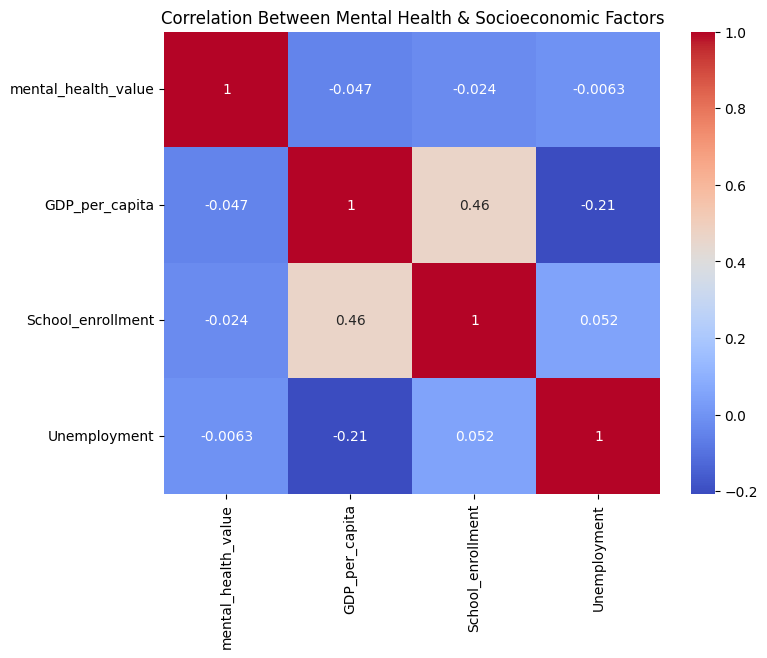

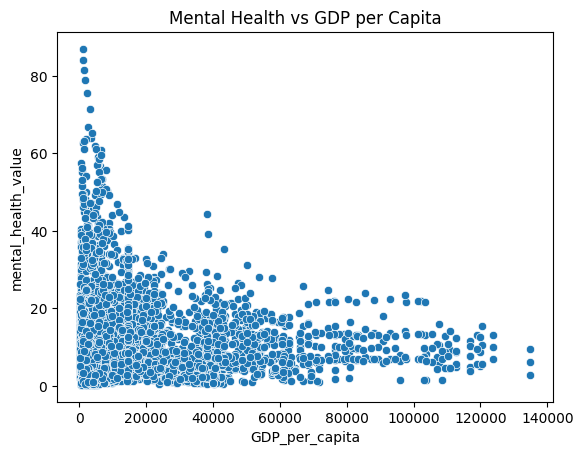

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trend of mental health over years
plt.figure(figsize=(12,6))
sns.lineplot(data=final_df, x="year", y="mental_health_value", ci=None)
plt.title("Mental Health Trends Over Years")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(final_df[["mental_health_value","GDP_per_capita","School_enrollment","Unemployment"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Mental Health & Socioeconomic Factors")
plt.show()

# Scatter plot: Mental health vs GDP per capita
sns.scatterplot(data=final_df, x="GDP_per_capita", y="mental_health_value")
plt.title("Mental Health vs GDP per Capita")
plt.show()


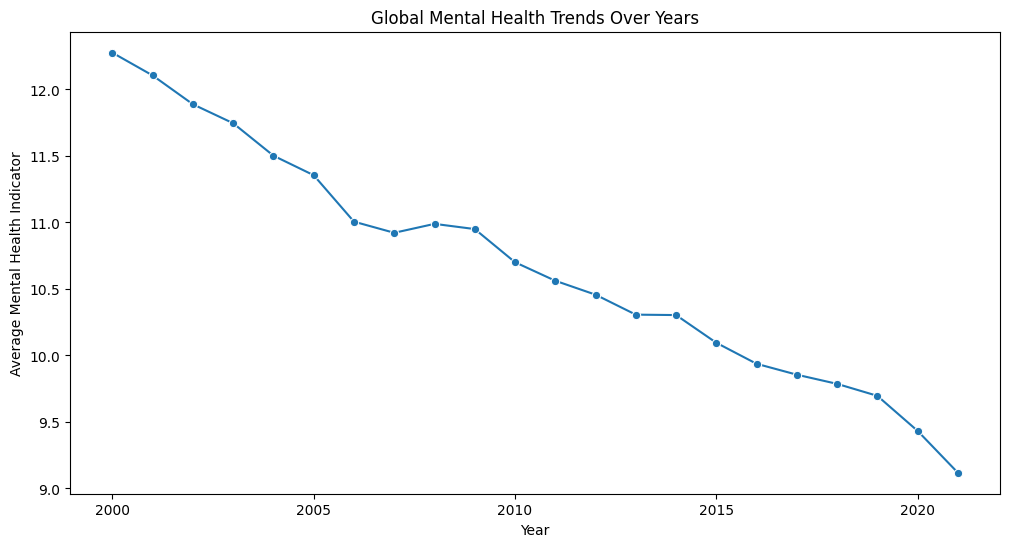

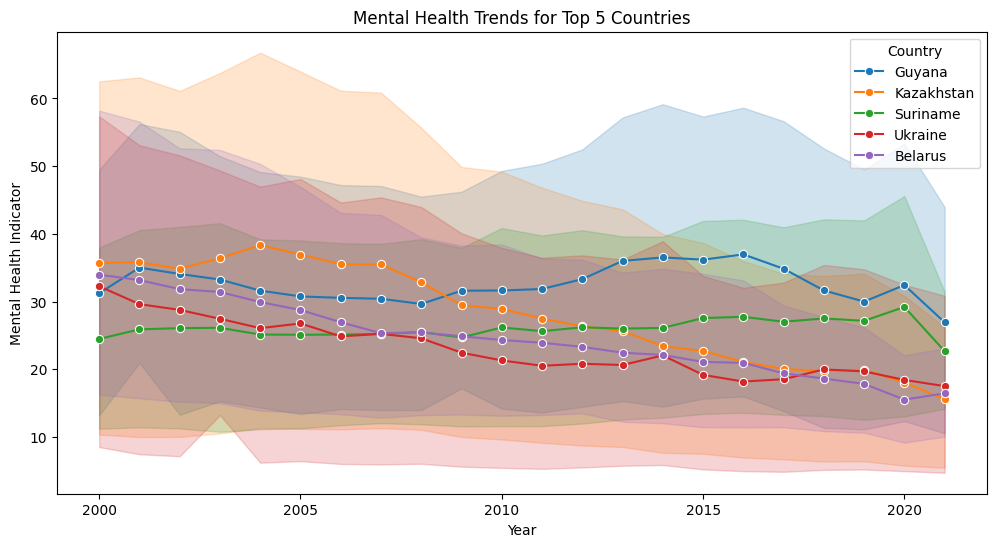

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Aggregate by year
yearly_trends = final_df.groupby("year")["mental_health_value"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=yearly_trends, x="year", y="mental_health_value", marker="o")
plt.title("Global Mental Health Trends Over Years")
plt.ylabel("Average Mental Health Indicator")
plt.xlabel("Year")
plt.show()

# Optional: Top 5 countries with highest mental health indicator trends
top_countries = final_df.groupby("country_name_y")["mental_health_value"].mean().sort_values(ascending=False).head(5).index
plt.figure(figsize=(12,6))
sns.lineplot(data=final_df[final_df["country_name_y"].isin(top_countries)], 
             x="year", y="mental_health_value", hue="country_name_y", marker="o")
plt.title("Mental Health Trends for Top 5 Countries")
plt.ylabel("Mental Health Indicator")
plt.xlabel("Year")
plt.legend(title="Country")
plt.show()


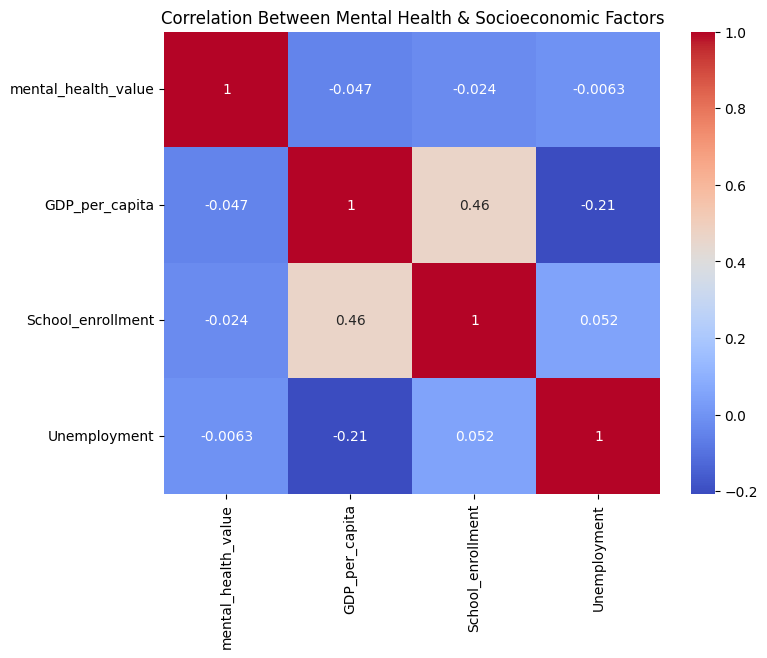

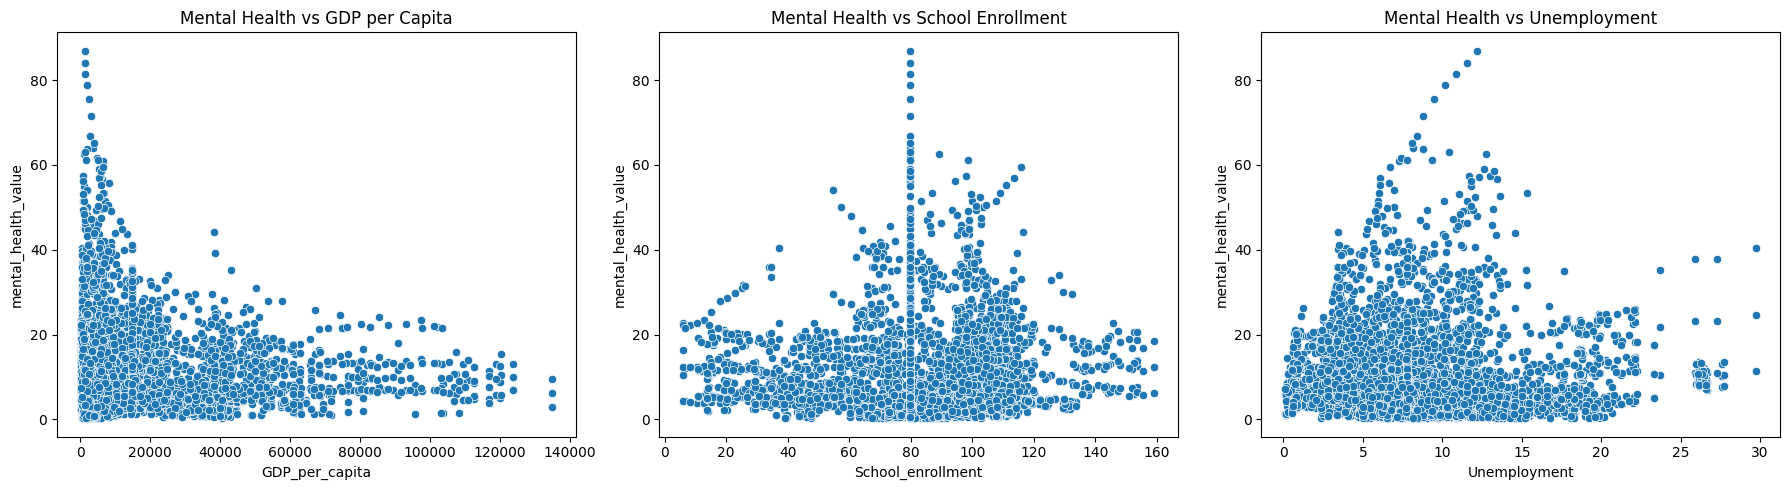

In [24]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(final_df[["mental_health_value","GDP_per_capita","School_enrollment","Unemployment"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Mental Health & Socioeconomic Factors")
plt.show()

# Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.scatterplot(data=final_df, x="GDP_per_capita", y="mental_health_value", ax=axes[0])
axes[0].set_title("Mental Health vs GDP per Capita")

sns.scatterplot(data=final_df, x="School_enrollment", y="mental_health_value", ax=axes[1])
axes[1].set_title("Mental Health vs School Enrollment")

sns.scatterplot(data=final_df, x="Unemployment", y="mental_health_value", ax=axes[2])
axes[2].set_title("Mental Health vs Unemployment")

plt.tight_layout()
plt.show()


C:\Users\lenovo\AppData\Local\Temp\ipykernel_42184\3650705205.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_trends = recent_df.groupby("country_name_y").apply(compute_slope).reset_index()


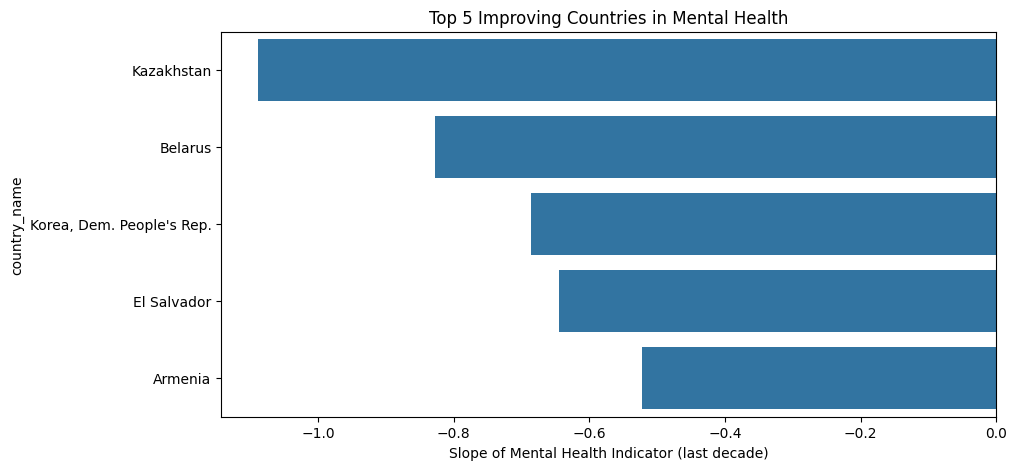

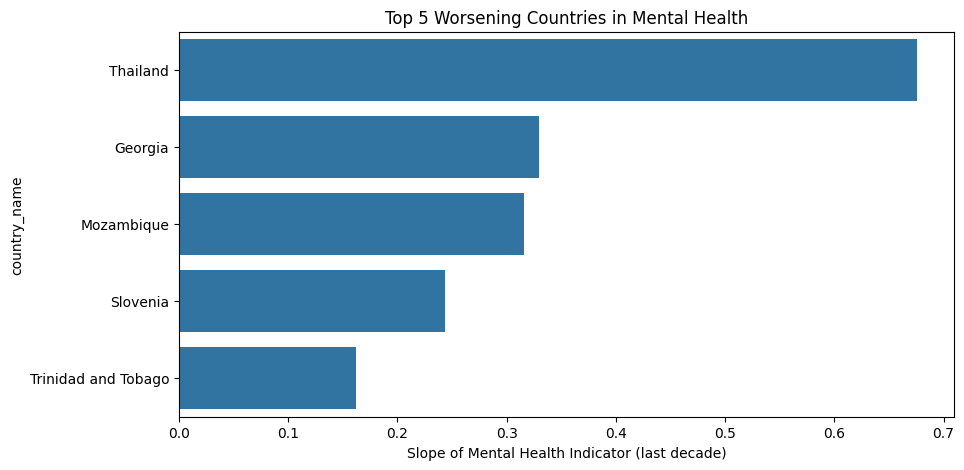

In [25]:
import numpy as np

recent_df = final_df[final_df["year"] >= final_df["year"].max()-10]

# Function to compute trend (slope) per country
def compute_slope(df):
    x = df["year"]
    y = df["mental_health_value"]
    if len(x) > 1:
        slope = np.polyfit(x, y, 1)[0]  # linear slope
        return slope
    else:
        return 0

country_trends = recent_df.groupby("country_name_y").apply(compute_slope).reset_index()
country_trends.columns = ["country_name", "slope"]

# Top 5 improving countries (negative slope = improving if lower values are better)
top_improving = country_trends.sort_values("slope").head(5)
top_worsening = country_trends.sort_values("slope", ascending=False).head(5)

plt.figure(figsize=(10,5))
sns.barplot(x="slope", y="country_name", data=top_improving)
plt.title("Top 5 Improving Countries in Mental Health")
plt.xlabel("Slope of Mental Health Indicator (last decade)")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x="slope", y="country_name", data=top_worsening)
plt.title("Top 5 Worsening Countries in Mental Health")
plt.xlabel("Slope of Mental Health Indicator (last decade)")
plt.show()


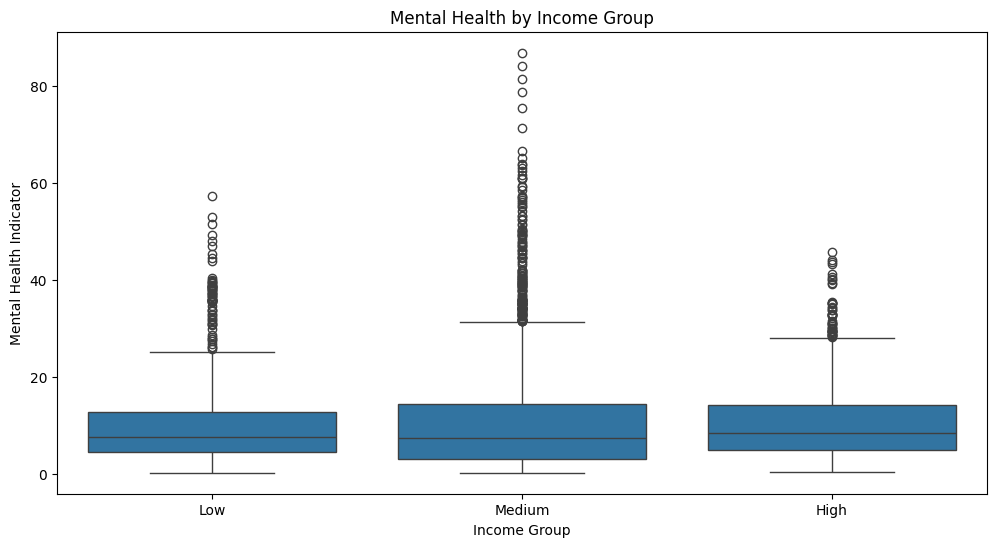

In [26]:
# Average GDP per country
avg_gdp = final_df.groupby("country_name_y")["GDP_per_capita"].mean().reset_index()
avg_gdp["income_group"] = pd.qcut(avg_gdp["GDP_per_capita"], 3, labels=["Low", "Medium", "High"])

# Merge income group back to main dataframe
df_income = final_df.merge(avg_gdp[["country_name_y","income_group"]], on="country_name_y", how="left")

plt.figure(figsize=(12,6))
sns.boxplot(data=df_income, x="income_group", y="mental_health_value")
plt.title("Mental Health by Income Group")
plt.xlabel("Income Group")
plt.ylabel("Mental Health Indicator")
plt.show()
